# EDB: Pin to Pin project

This example demonstrates the use of the Electronics
Database (EDB) interface to create a layout using the BOM and
a configuration file.

## Perform required imports

The ``Hfss3dlayout`` class provides an interface to
the 3D Layout editor in AEDT.
on version 2023 R2.

In [1]:
import os
import tempfile

import ansys.aedt.core

import pyedb
from pyedb.misc.downloads import download_file


Download the AEDB file and copy it to a temporary folder.

In [2]:
temp_dir = tempfile.TemporaryDirectory(suffix=".ansys")
target_aedb = download_file("edb/ANSYS-HSD_V1.aedb", destination=temp_dir.name)
print("Project folder is", target_aedb)

Project folder is C:\Users\ansys\AppData\Local\Temp\tmp3azs_8uz.ansys\edb/ANSYS-HSD_V1.aedb


## Launch EDB

Launch the ``pyedb.Edb`` class using EDB 2023 R2. Length units are SI.

In [3]:
# Select EDB version (change it manually if needed, e.g. "2024.2")
edb_version = "2024.2"
print(f"EDB version: {edb_version}")

edbapp = pyedb.Edb(target_aedb, edbversion=edb_version)

EDB version: 2024.2


PyAEDT INFO: Logger is initialized in EDB.


PyAEDT INFO: legacy v0.36.0


PyAEDT INFO: Python version 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]


PyAEDT INFO: Database ANSYS-HSD_V1.aedb Opened in 2024.2


PyAEDT INFO: Cell main Opened


PyAEDT INFO: Builder was initialized.


PyAEDT INFO: EDB initialized.


## Import definitions

The definition file uses the [json](https://www.json.org/json-en.html) to
map layout part numbers to their corresponding models.

The model may be an RLC, S-parameter, or
[SPICE](https://en.wikipedia.org/wiki/SPICE) model definition.
Once imported, the definition is applied to the components in the layout.
In this example, the JSON file is in the ``*.aedb`` folder and has the following format:
``` json
{
    "SParameterModel": {
        "GRM32_DC0V_25degC_series": "./GRM32_DC0V_25degC_series.s2p"
    },
    "SPICEModel": {
        "GRM32_DC0V_25degC": "./GRM32_DC0V_25degC.mod"
    },
    "Definitions": {
        "CAPC1005X05N": {
            "Component_type": "Capacitor",
            "Model_type": "RLC",
            "Res": 1,
            "Ind": 2,
            "Cap": 3,
            "Is_parallel": false
        },
        "'CAPC3216X180X55ML20T25": {
            "Component_type": "Capacitor",
            "Model_type": "SParameterModel",
            "Model_name": "GRM32_DC0V_25degC_series"
        },
        "'CAPC3216X180X20ML20": {
            "Component_type": "Capacitor",
            "Model_type": "SPICEModel",
            "Model_name": "GRM32_DC0V_25degC"
        }
    }
}
```

The ``Edb.components.import_definitions()`` method imports the component definitions that map
electrical models to the components in the simulation model.

In [4]:
edbapp.components.import_definition(os.path.join(target_aedb, "1_comp_definition.json"))

True

## Import BOM

The bill of materials (BOM) file provides the list of all components
by reference designator, part name, component type, and nominal value.

Components that are not contained in the BOM are deactivated in the
simulation model.
This example saves the CSV file in the ``aedb`` folder.

```
+------------+-----------------------+-----------+------------+
| RefDes     | Part name             | Type      | Value      |
+============+=======================+===========+============+
| C380       | CAPC1005X55X25LL05T10 | Capacitor | 11nF       |
+------------+-----------------------+-----------+------------+
```

Having red the information in the BOM and definitions file, electrical models can be
assigned to all of the components in the simulation model.

In [5]:
edbapp.components.import_bom(
    os.path.join(target_aedb, "0_bom.csv"),
    refdes_col=0,
    part_name_col=1,
    comp_type_col=2,
    value_col=3,
)

PyAEDT INFO: RLC properties for Component C380 has been assigned.


True

## Verify a Component

Component property allows to access all components instances and their property with
getters and setters.

In [6]:
comp = edbapp.components["C1"]
comp.model_type, comp.value

('RLC', 1.0000000000000001e-07)

## Check component definition

When an s-parameter model is associated to a component it will be available in
nport_comp_definition property.

In [7]:
edbapp.components.nport_comp_definition
edbapp.save_edb()

PyAEDT INFO: EDB file save time: 0.00ms


True

## Configure the simulation setup

This step enables the following:

- Definition of the nets to include in the cutout region
- Cutout details
- Components to create the ports on
- Simulation settings

The ``Edb.new_simulaton_configuration()`` method returns an instance
of the ``SimulationConfiguration`` class.

In [8]:
sim_setup = edbapp.new_simulation_configuration()
sim_setup.solver_type = sim_setup.SOLVER_TYPE.SiwaveSYZ
sim_setup.batch_solve_settings.cutout_subdesign_expansion = 0.003
sim_setup.batch_solve_settings.do_cutout_subdesign = True
sim_setup.batch_solve_settings.use_pyaedt_cutout = True
sim_setup.ac_settings.max_arc_points = 6
sim_setup.ac_settings.max_num_passes = 5

sim_setup.batch_solve_settings.signal_nets = [
    "PCIe_Gen4_TX2_CAP_P",
    "PCIe_Gen4_TX2_CAP_N",
    "PCIe_Gen4_TX2_P",
    "PCIe_Gen4_TX2_N",
]
sim_setup.batch_solve_settings.components = ["U1", "X1"]
sim_setup.batch_solve_settings.power_nets = ["GND", "GND_DP"]
sim_setup.ac_settings.start_freq = "100Hz"
sim_setup.ac_settings.stop_freq = "6GHz"
sim_setup.ac_settings.step_freq = "10MHz"

## Implement the setup

The cutout and all other simulation settings are applied to the simulation model.

In [9]:
sim_setup.export_json(os.path.join(temp_dir.name, "configuration.json"))
edbapp.build_simulation_project(sim_setup)

PyAEDT INFO: Building simulation project.


PyAEDT INFO: Cutting out using method: 1


PyAEDT INFO: Cutting out using method: 1


PyAEDT INFO: Cutout Multithread started.


PyAEDT INFO: Net clean up Elapsed time: 0m 2sec


PyAEDT INFO: Correctly computed Extension at first iteration.


PyAEDT INFO: Extent Creation Elapsed time: 0m 0sec


PyAEDT INFO: 1984 Padstack Instances deleted. Elapsed time: 0m 1sec


PyAEDT INFO: 444 Primitives deleted. Elapsed time: 0m 2sec


PyAEDT INFO: 978 components deleted


PyAEDT INFO: Deleted 470 components


PyAEDT INFO: Single Pins components deleted Elapsed time: 0m 0sec


PyAEDT INFO: Cutout completed. Elapsed time: 0m 5sec


PyAEDT INFO: Cutout processed.


PyAEDT INFO: Deleting existing ports.


PyAEDT INFO: No pins found on component Ansys.Ansoft.Edb.Cell.Hierarchy.Component for the net PCIe_Gen4_TX2_P


PyAEDT INFO: No pins found on component Ansys.Ansoft.Edb.Cell.Hierarchy.Component for the net PCIe_Gen4_TX2_N


PyAEDT INFO: No pins found on component Ansys.Ansoft.Edb.Cell.Hierarchy.Component for the net PCIe_Gen4_TX2_CAP_P


PyAEDT INFO: No pins found on component Ansys.Ansoft.Edb.Cell.Hierarchy.Component for the net PCIe_Gen4_TX2_CAP_N


PyAEDT INFO: Configuring analysis setup.


PyAEDT INFO: Adding frequency sweep


PyAEDT INFO: Padstack definition with zero plating ratio, defaulting to 20%


PyAEDT INFO: Padstack definition with zero plating ratio, defaulting to 20%


PyAEDT INFO: Padstack definition with zero plating ratio, defaulting to 20%


PyAEDT INFO: Padstack definition with zero plating ratio, defaulting to 20%


PyAEDT INFO: Padstack definition with zero plating ratio, defaulting to 20%


PyAEDT INFO: Padstack definition with zero plating ratio, defaulting to 20%


PyAEDT INFO: EDB file save time: 0.00ms


True

## Display the cutout

Plot cutout once finished. The model is ready to simulate.

PyAEDT INFO: Plot Generation time 0.313


(<Figure size 6000x3000 with 1 Axes>, <Axes: title={'center': 'Edb Top View'}>)

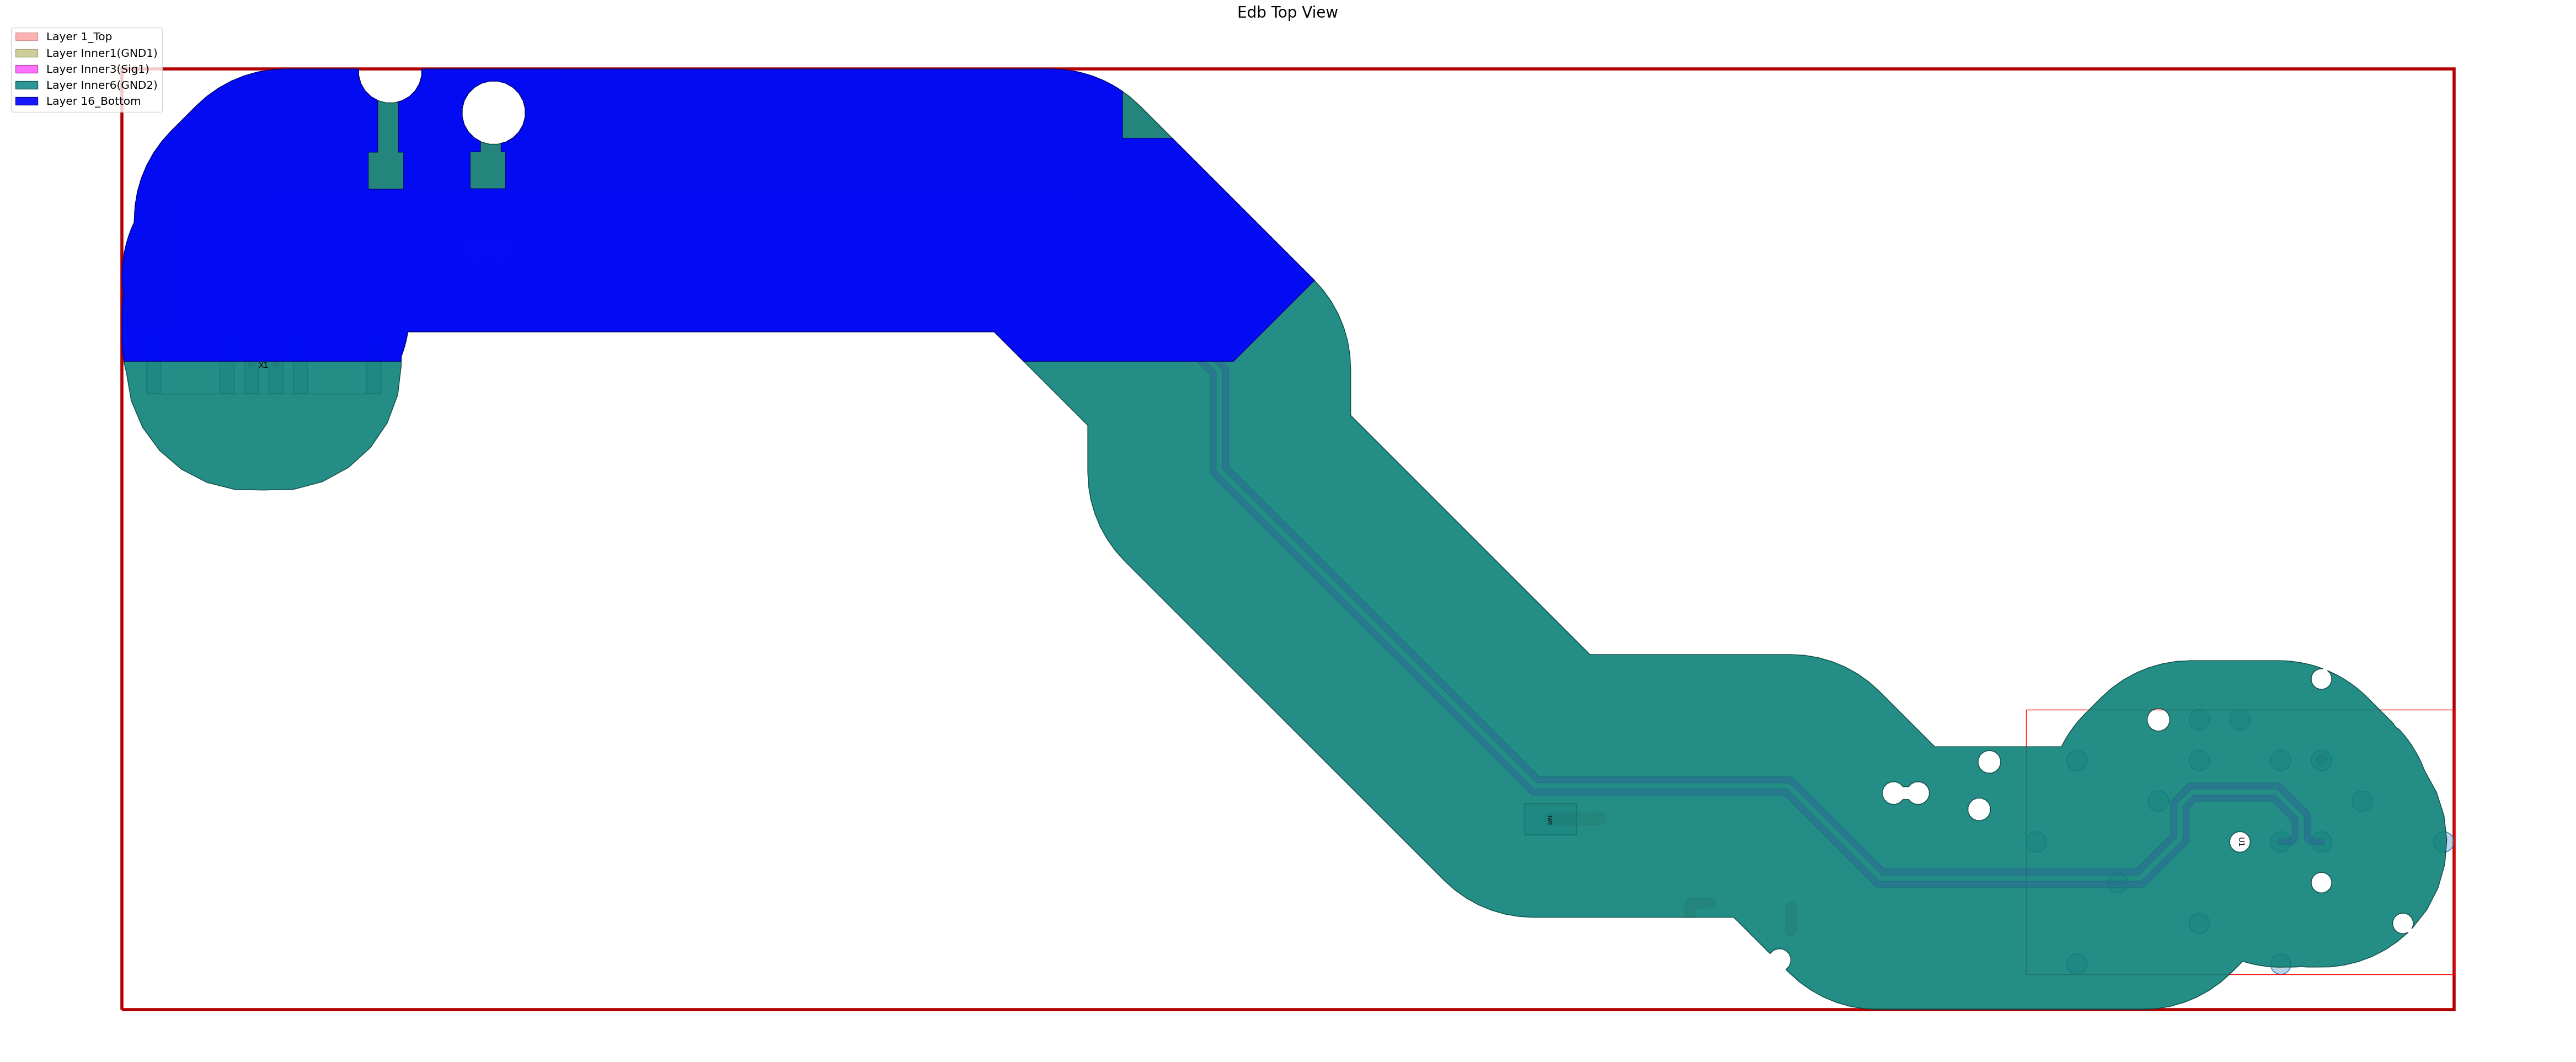

In [10]:
edbapp.nets.plot(None, None)

## Save and close EDB

EDB is saved and re-opened in HFSS
3D Layout, where the HFSS simulation can be run.

In [11]:
edbapp.save_edb()
edbapp.close_edb()

PyAEDT INFO: EDB file save time: 0.00ms


PyAEDT INFO: EDB file release time: 15.63ms


True

## Open Electronics Desktop

The EDB is opened in AEDT Hfss3DLayout.

Set ``non_graphical=True`` to run the simulation in non-graphical mode.

In [12]:
aedt_version = edb_version

In [13]:
h3d = ansys.aedt.core.Hfss3dLayout(
    specified_version=aedt_version,
    projectname=target_aedb,
    non_graphical=False,
    new_desktop_session=False,
)

PyAEDT WARNING: Argument `projectname` is deprecated for method `__init__`; use `project` instead.


PyAEDT WARNING: Argument `specified_version` is deprecated for method `__init__`; use `version` instead.


PyAEDT WARNING: Argument `new_desktop_session` is deprecated for method `__init__`; use `new_desktop` instead.


PyAEDT INFO: Python version 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]


PyAEDT INFO: PyAEDT version 0.14.dev0.


PyAEDT INFO: Initializing new Desktop session.


PyAEDT INFO: Log on console is enabled.


PyAEDT INFO: Log on file C:\Users\ansys\AppData\Local\Temp\pyaedt_ansys_5bf840b7-1e6e-4568-8ed7-6a758d0a75ce.log is enabled.


PyAEDT INFO: Log on AEDT is enabled.


PyAEDT INFO: Debug logger is disabled. PyAEDT methods will not be logged.


PyAEDT INFO: Launching PyAEDT with gRPC plugin.


PyAEDT INFO: New AEDT session is starting on gRPC port 50471


PyAEDT INFO: AEDT installation Path C:\Program Files\AnsysEM\v242\Win64


PyAEDT INFO: Ansoft.ElectronicsDesktop.2024.2 version started with process ID 1548.


PyAEDT INFO: EDB folder C:\Users\ansys\AppData\Local\Temp\tmp3azs_8uz.ansys\edb/ANSYS-HSD_V1.aedb has been imported to project ANSYS-HSD_V1


PyAEDT INFO: Active Design set to 0;main


PyAEDT INFO: Aedt Objects correctly read


## Analyze

This project is ready to solve.
Executing the following cell runs the HFSS simulation on the layout.

In [14]:
h3d.analyze()

PyAEDT INFO: Key Desktop/ActiveDSOConfigurations/HFSS 3D Layout Design correctly changed.


PyAEDT INFO: Solving all design setups.


PyAEDT INFO: Key Desktop/ActiveDSOConfigurations/HFSS 3D Layout Design correctly changed.


PyAEDT INFO: Design setup None solved correctly in 0.0h 0.0m 37.0s


True

## View results

S-parameter data is loaded at the end of simulation.

In [15]:
solutions = h3d.post.get_solution_data()

PyAEDT INFO: Parsing C:/Users/ansys/AppData/Local/Temp/tmp3azs_8uz.ansys/edb/ANSYS-HSD_V1.aedt.


PyAEDT INFO: File C:/Users/ansys/AppData/Local/Temp/tmp3azs_8uz.ansys/edb/ANSYS-HSD_V1.aedt correctly loaded. Elapsed time: 0m 0sec


PyAEDT INFO: aedt file load time 0.04799342155456543


PyAEDT INFO: PostProcessor class has been initialized! Elapsed time: 0m 0sec


PyAEDT INFO: Post class has been initialized! Elapsed time: 0m 0sec


PyAEDT INFO: Solution Data Correctly Loaded.


## Plot results

Plot S-Parameter data.

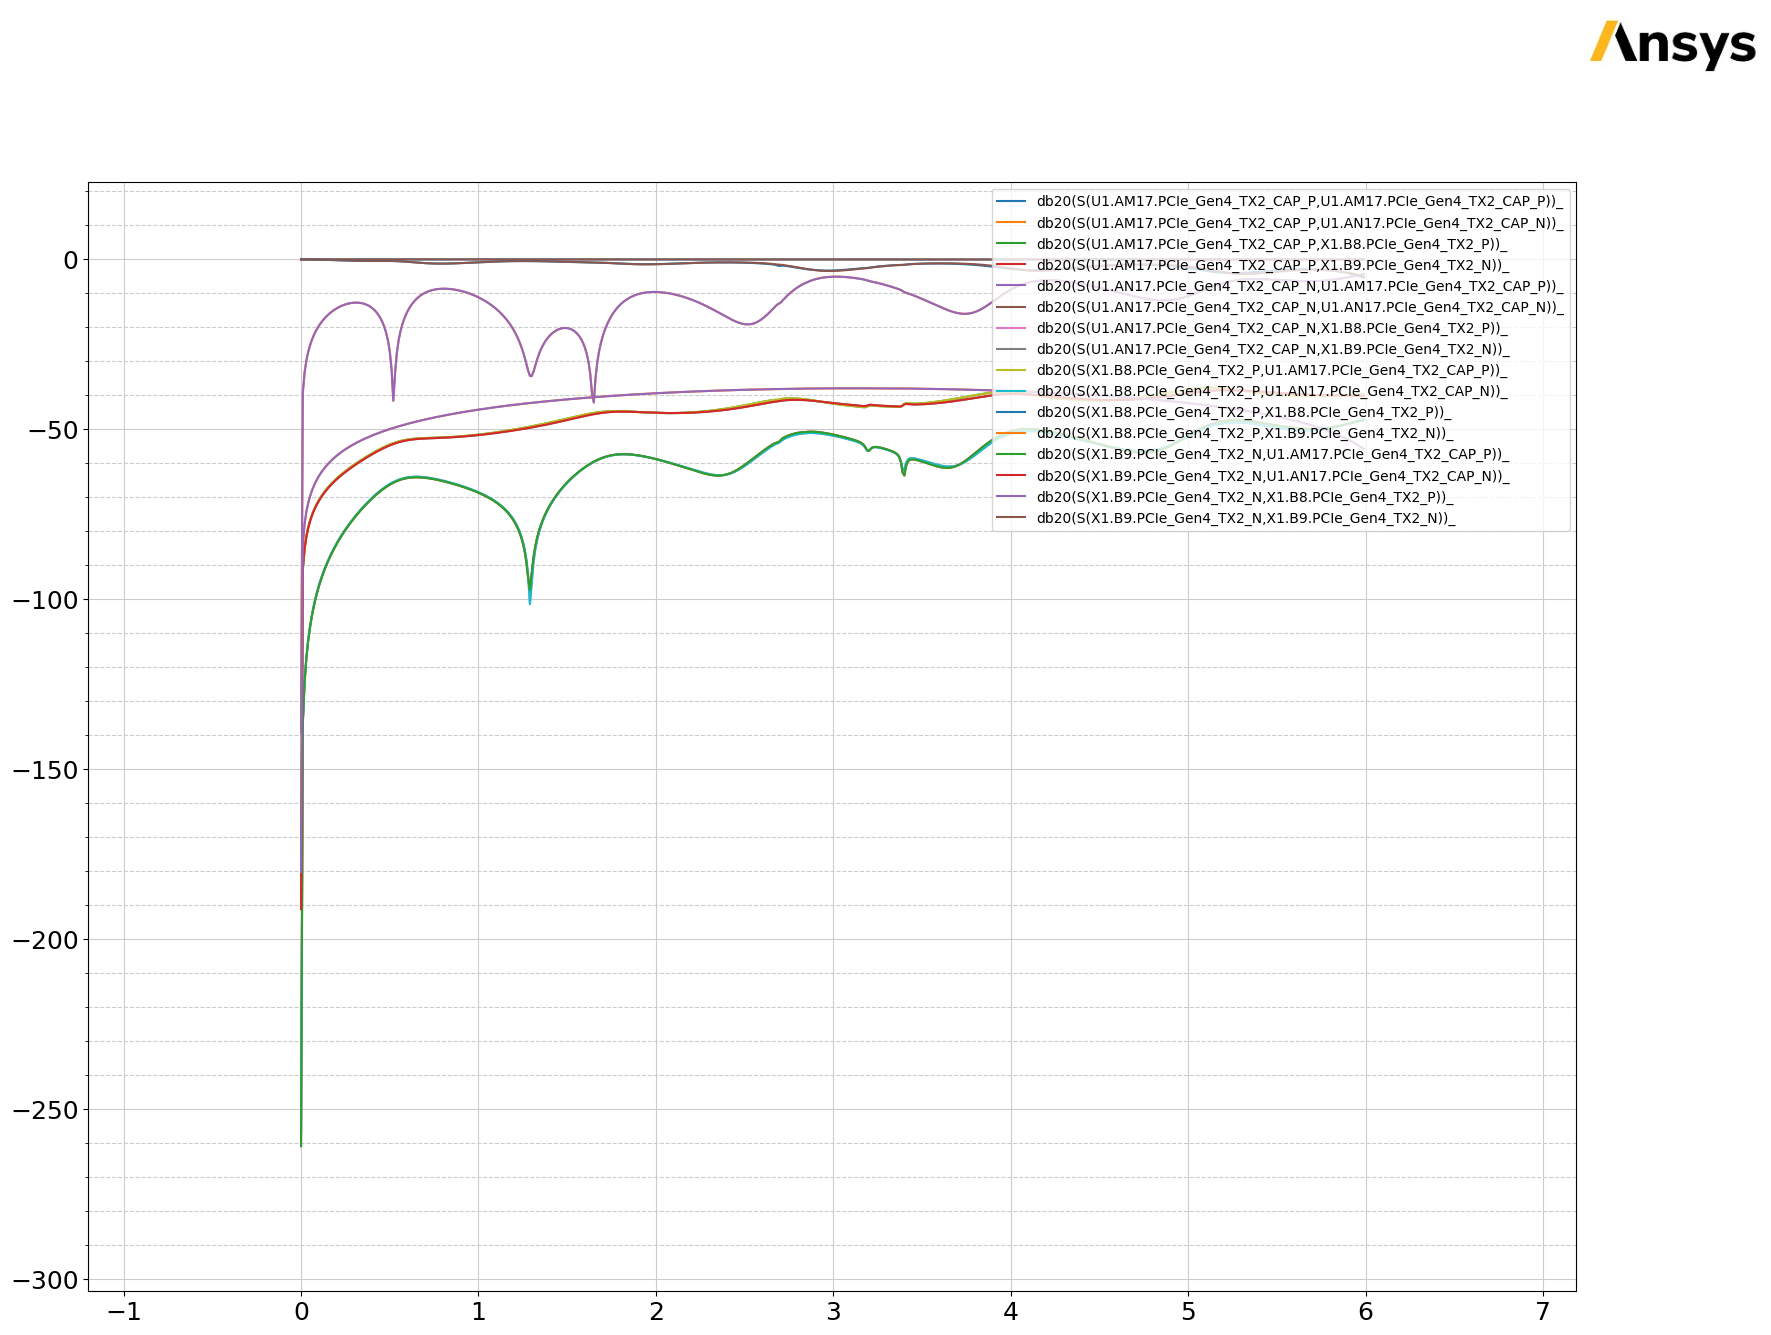

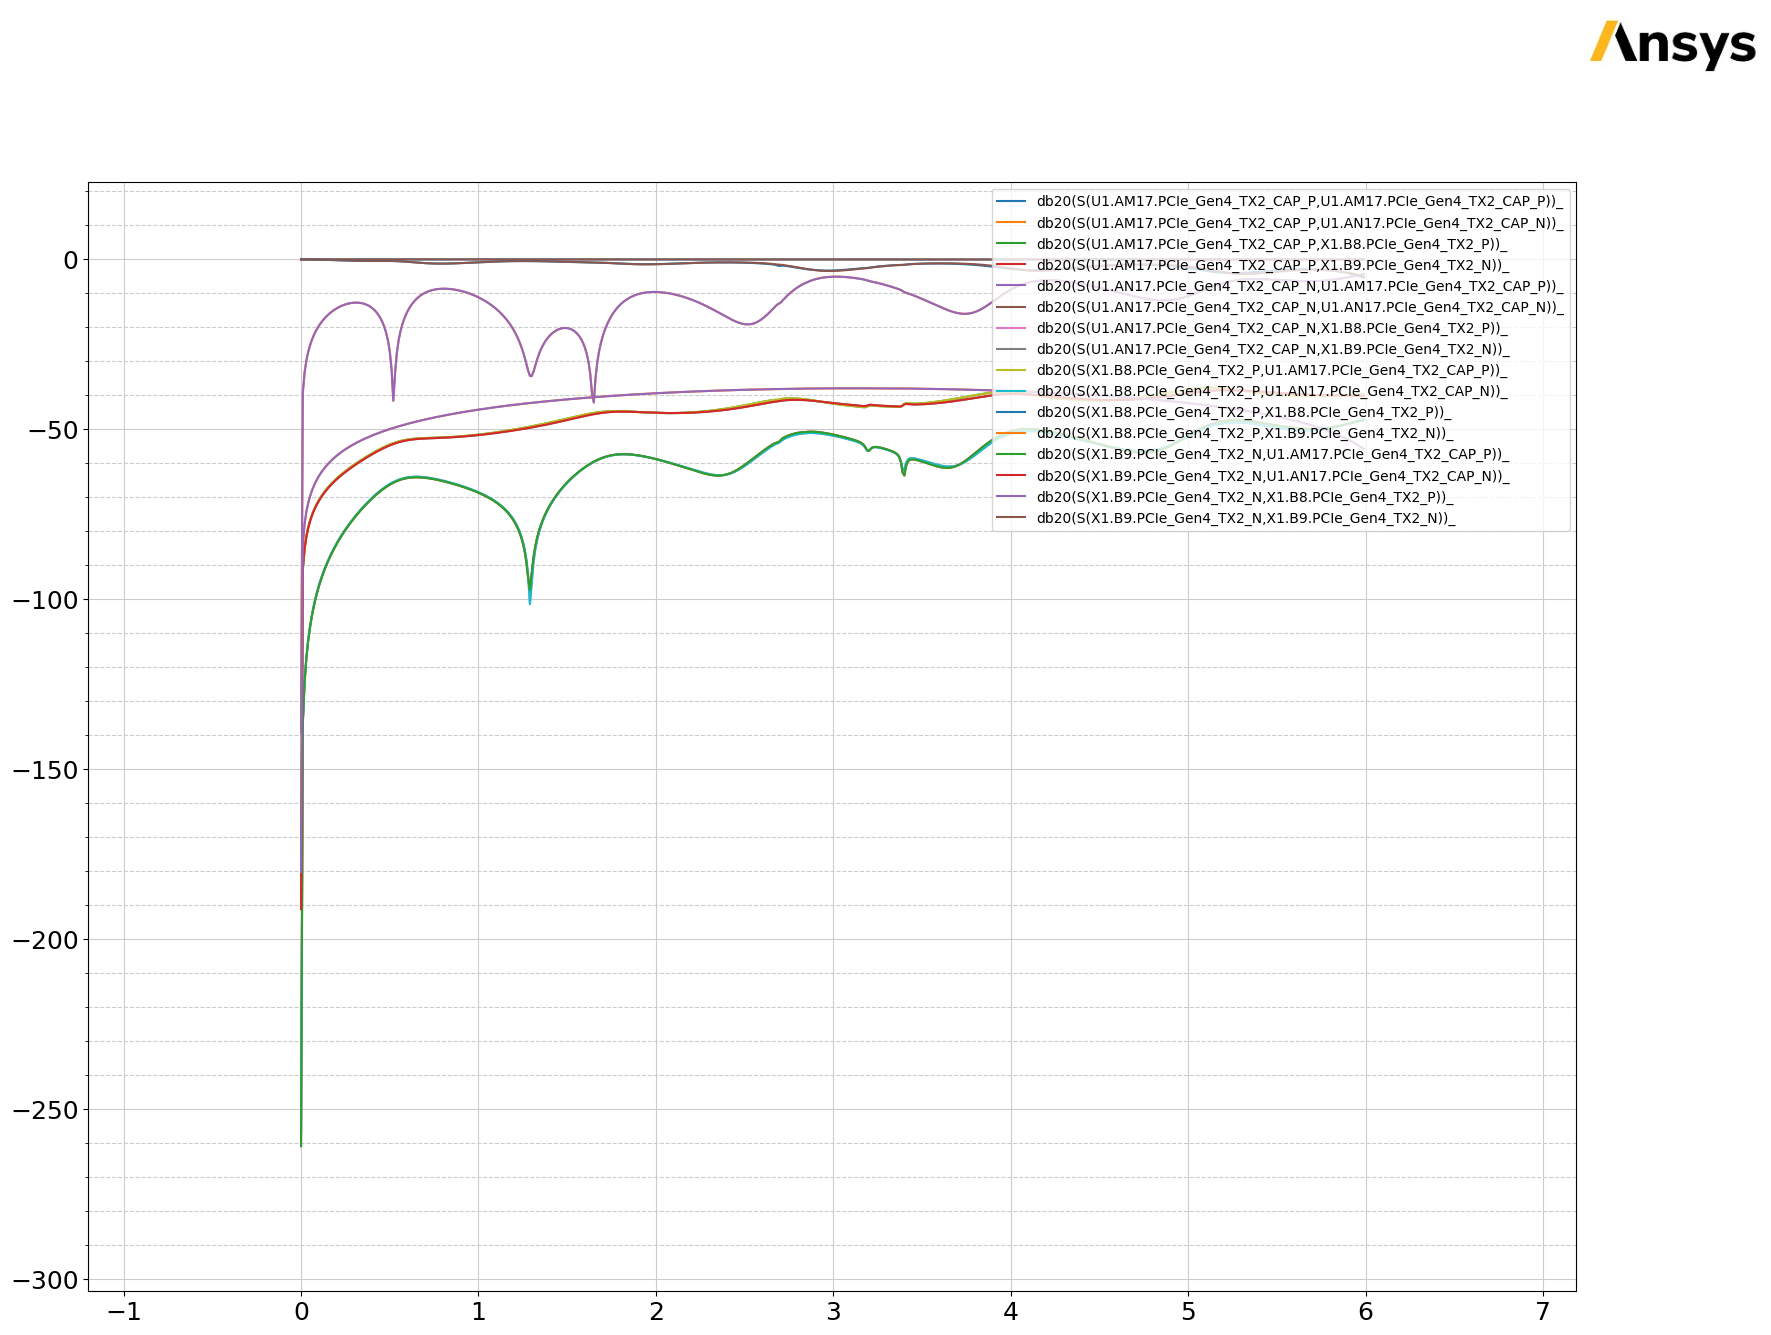

In [16]:
solutions.plot(solutions.expressions, "db20")

## Save and close AEDT

HFSS 3D Layout is saved and closed.

In [17]:
h3d.save_project()
h3d.release_desktop()

PyAEDT INFO: Project ANSYS-HSD_V1 Saved correctly


PyAEDT INFO: Desktop has been released and closed.


True

Clean up the temporary directory. All files and the temporary project
folder will be deleted in the next step.

In [18]:
temp_dir.cleanup()